In [1]:
import os
import random
import math
import kornia
import numpy as np
import pandas as pd
import pdb
from collections import OrderedDict
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import collections  as mc
matplotlib.rcParams['figure.figsize'] = [6, 6]
matplotlib.rcParams['figure.dpi'] = 200

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms

from data_helper import UnlabeledDataset, LabeledDataset
from helper import draw_box

# random.seed(0)
# np.random.seed(0)
# torch.manual_seed(0);

# All the images are saved in image_folder
# All the labels are saved in the annotation_csv file
image_folder = '/scratch/brs426/data'
annotation_csv = '/scratch/brs426/data/annotation.csv'

# You shouldn't change the unlabeled_scene_index
# The first 106 scenes are unlabeled
unlabeled_scene_index = np.arange(106)
# The scenes from 106 - 133 are labeled
# You should devide the labeled_scene_index into two subsets (training and validation)
train_labeled_scene_index = np.arange(106, 132)
val_labeled_scene_index = np.arange(132, 134)
test_labeled_scene_index = np.arange(132, 134)

from helper import compute_ats_bounding_boxes, compute_ts_road_map

from math import acos
from math import sqrt
from math import pi

In [2]:
def length(v):
    return sqrt(v[0]**2+v[1]**2)

def dot_product(v,w):
    return v[0]*w[0]+v[1]*w[1]

def determinant(v,w):
    return v[0]*w[1]-v[1]*w[0]

def inner_angle(v,w):
    cosx=dot_product(v,w)/(length(v)*length(w))
    rad=acos(cosx) # in radians
    return rad*180/pi # returns degrees

def angle_clockwise(A, B):
    inner=inner_angle(A,B)
    det = determinant(A,B)
    if det<0: #this is a property of the det. If the det < 0 then B is clockwise of A
        return inner
    else: # if the det > 0 then A is immediately clockwise of B
        return 360-inner

In [3]:
def within_angles(xs, ys, angle1 = 270, angle2 = 330):
    '''
    xs and ys must be corresponding coordinates in matplotlib-space (y-axis 0 starts from the top).
    '''
    
    # Matplotlib y-axis -- 0 starts from the top, so we need to adjust. 
    v0 = np.array([xs[0] - 400, 800 - ys[0] - 400])
    v1 = np.array([xs[1] - 400, 800 - ys[1] - 400])
    v2 = np.array([xs[2] - 400, 800 - ys[2] - 400])
    v3 = np.array([xs[3] - 400, 800 - ys[3] - 400])
    v_ref = np.array([2, 0])
    
    condition = (angle_clockwise(v_ref, v0) >= angle1 and angle_clockwise(v_ref, v0) <= angle2) or \
                (angle_clockwise(v_ref, v1) >= angle1 and angle_clockwise(v_ref, v1) <= angle2) or \
                (angle_clockwise(v_ref, v2) >= angle1 and angle_clockwise(v_ref, v2) <= angle2) or \
                (angle_clockwise(v_ref, v3) >= angle1 and angle_clockwise(v_ref, v3) <= angle2)
    return condition

In [4]:
BLOCK_SIZE = 5

In [5]:
def blur(img):
    img = img.unsqueeze(0)
    blurred = kornia.filters.gaussian_blur2d(img, kernel_size=(5, 5), sigma=(9.5, 9.5))
    return blurred.squeeze(0)

In [23]:
def collate_fn(batch):
    BLOCK_SIZE = 5
    left_images = []
    target = []
    road_maps = []
    bbox_maps = []
    bbox_bins = []
    bbs = []
    target_counts = []
    for x in batch:
        
        # Get road_image and cast it to float
        road_image = torch.as_tensor(x[2]).float()
        road_maps.append(road_image)
        
        # Collect six images for this sample. 
        # TODO: Try cutting off the top 100 pixels (that can lead to overfitting)
        image = torch.Tensor(x[0][0])[:, 120:, :]
        left_images.append(image)
        
        # target
        bb_tens = x[1]['bounding_box']
        current_bbs = []
        bbox_map = torch.zeros((800, 800))
        counts = np.zeros(8)
        count = 0
        
        # Create the bounding box map. 
        for i, corners in enumerate(bb_tens):
            
            # Grab the current bounding box. 
            current_bbs.append(corners)
            
            # Get its four bird's-eye view coordinates. 
            point_squence = torch.stack([corners[:, 0], corners[:, 1], corners[:, 3], corners[:, 2]])
            xs = point_squence.T[0] * 10 + 400
            ys = -point_squence.T[1] * 10 + 400
            
            # xs is horizontal, ys is vertical through. 
            # But we're doing things row, column way. 
            
            # Only get the bounding boxes that are close-by. On the same road. 
            # We want to see if the model can fucking predict cars that are close by. 
            
            center_x, center_y = torch.mean(xs).item(), torch.mean(ys).item()
            if within_angles(xs, ys) and center_y > 300 and center_y < 525:
            
                # Grab the top-left coordinates. 
                r, c = int(torch.min(ys).item()), int(torch.min(xs).item())
                r_len, c_len = int(torch.max(ys).item()) - r, int(torch.max(xs).item()) - c

                # Fill in the bbox. 
                bbox_map[r:r+r_len, c:c+c_len] = 1.0

                count += 1
            
        # Convert the bounding box map into classes (5px by 5px bins)
        bbox_grid = []
        for x_ in range(0, 800, BLOCK_SIZE):
            for y in range(0, 800, BLOCK_SIZE):
                block = bbox_map[x_:x_+BLOCK_SIZE, y:y+BLOCK_SIZE]
                score = torch.sum(block).item()
                # If more than have the pixels are 1, classify as bbox car
                if score > 0.5 * (BLOCK_SIZE**2):
                    bbox_grid.append(1.0)
                else:
                    bbox_grid.append(0.0)
                    
        bbox_bins.append(torch.Tensor(bbox_grid))
              
        counts[count] = 1

        # Label Smoothing #
#         if count > 15 and count < 88:
#             counts[count+1] = 0.2
#             counts[count-1] = 0.2
            
        target_counts.append(torch.Tensor(counts))
        
        bbox_maps.append(bbox_map)

        bbs.append(current_bbs)
                
    boom = torch.stack(left_images), torch.stack(bbox_bins), torch.stack(road_maps), bbs, torch.stack(target_counts), torch.stack(bbox_maps) 
    return boom

In [24]:
val_transform = transforms.ToTensor()

train_transform = transforms.Compose([
    transforms.ColorJitter(brightness = 0.5, contrast = 0.5, saturation = 0.4, hue = (-0.5, 0.5)),
    transforms.RandomApply([
        transforms.Grayscale(3),
#         transforms.RandomAffine(1),
    ]),
    transforms.ToTensor(),
    transforms.RandomApply([
        transforms.Lambda(lambda img: blur(img)),
    ])
])

labeled_trainset = LabeledDataset(image_folder=image_folder,
                                  annotation_file=annotation_csv,
                                  scene_index=train_labeled_scene_index,
                                  transform=train_transform,
                                  extra_info=True
                                 )

labeled_valset = LabeledDataset(image_folder=image_folder,
                                  annotation_file=annotation_csv,
                                  scene_index=val_labeled_scene_index,
                                  transform=val_transform,
                                  extra_info=True
                                 )

#### Testing

In [25]:
train_loader = torch.utils.data.DataLoader(labeled_trainset, batch_size=16, shuffle=True, collate_fn=collate_fn)

In [26]:
# Compute threat scores
def reconstruct_from_bins(bins, block_size, threshold):
    print(bins.shape)
    road_map = torch.zeros((800, 800))
    idx = 0
    for x in range(0, 800, block_size):
        for y in range(0, 800, block_size):
            road_map[x:x+block_size, y:y+block_size] = bins[idx]
            idx += 1
    return road_map > threshold

In [27]:
sample, bbox_bins, road_maps, bbs, counts, bbox_maps  = iter(train_loader).next()

In [28]:
idx = -1

In [35]:
idx += 1

tensor(1)


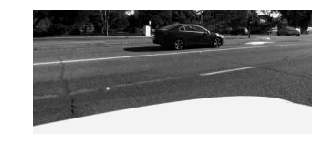

In [36]:
print(torch.argmax(counts[idx]))
matplotlib.rcParams['figure.figsize'] = [5,5]
plt.imshow(sample[idx].numpy().transpose(1, 2, 0))
plt.axis('off');

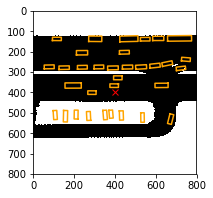

In [362]:
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = [3,3]
fig, ax = plt.subplots()
ax.imshow(road_maps[idx], cmap ='binary');
ax.plot(400, 400, 'x', color="red")
for bb in bbs[idx]:
    draw_box(ax, bb, 'orange')

torch.Size([25600])


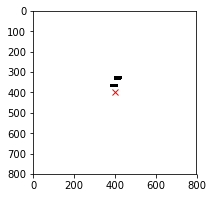

In [363]:
threshold = 0.5
road_map = reconstruct_from_bins(bbox_bins[idx], BLOCK_SIZE, threshold)
fig, ax = plt.subplots()
ax.imshow(road_map, cmap ='binary');
ax.plot(400, 400, 'x', color="red")

### Model

In [37]:
class SimpleModel(nn.Module):
    def __init__(self):
        super(SimpleModel, self).__init__()
        
        self.encoder = torchvision.models.resnet18()
        self.encoder.fc = nn.Identity()
        self.concat_dim = 100
        self.dropout = nn.Dropout(p = 0.2)
        self.bn = nn.BatchNorm1d(self.concat_dim)
        
        self.compress = nn.Sequential(OrderedDict([
            ('linear0', nn.Linear(512, 100)),
            ('relu', nn.ReLU()),
        ]))
        
        self.vehicle_map = nn.Sequential(OrderedDict([
            ('linear1_vehicle', nn.Linear(self.concat_dim, 25600)),
        ]))
        
        self.counts = nn.Sequential(OrderedDict([
            ('count1', nn.Linear(self.concat_dim, 8))
        ]))
        
    def forward(self, x):
        
        batch_size = x.shape[0]
        channels = x.shape[1]
        height = x.shape[2]
        width = x.shape[3]
        # Reshape here
        x = x.view(-1, channels, height, width)
        x = self.encoder(x)
        x = self.compress(x)
        x = x.view(-1, self.concat_dim)
        x = self.bn(x)
        x = self.dropout(x)
    
        return self.vehicle_map(x), self.counts(x)

In [38]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimpleModel()

model = model.to(device)
map_criterion = nn.BCEWithLogitsLoss()
count_criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=2e-4)
best_val_loss = 100

In [39]:
def train():
    model.train()
    labeled_trainset = LabeledDataset(image_folder=image_folder,
                                  annotation_file=annotation_csv,
                                  scene_index=train_labeled_scene_index,
                                  transform=train_transform,
                                  extra_info=True
                                 )
    train_loader = torch.utils.data.DataLoader(labeled_trainset, batch_size=15, num_workers=15, shuffle=True, collate_fn=collate_fn)
    
    train_losses = []
    map_losses = []
    count_losses = []
    f = open(log_file_path, "a+")
    for i, (sample, bbox_bins, road_maps, bbs, target_count, _) in enumerate(train_loader):
        optimizer.zero_grad()

        sample = sample.to(device)
        bbox_bins = bbox_bins.to(device)
        target_count = target_count.to(device)
        
        y_vehicle, y_count = model(sample)
        
        map_loss = map_criterion(y_vehicle, bbox_bins.float())
        count_loss = count_criterion(y_count, target_count.float())
        loss = map_loss + count_loss
        
        loss.backward()
        optimizer.step()
        
        train_losses.append(loss.item())
        map_losses.append(map_loss.item())
        count_losses.append(count_loss.item())
        if i % 50 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, i * len(sample), len(train_loader.dataset),
                50. * i / len(train_loader), loss.item()))
            
    print("\nAverage Train Epoch Loss: ", np.mean(train_losses))
    print("Average Train Map Loss: ", np.mean(map_losses))
    print("Average Train Count Epoch Loss: ", np.mean(count_losses))
    
    f.write("\nAverage Train Epoch Loss: {}".format(np.mean(train_losses)))
    f.write("Average Train Map Loss: {}".format(np.mean(map_losses)))
    f.write("Average Train Count Epoch Loss: {}".format(np.mean(count_losses)))
    
    f.close()
    
            
def val():
    
    val_loader = torch.utils.data.DataLoader(labeled_valset, batch_size=15, num_workers=5, shuffle=True, collate_fn=collate_fn)
    model.eval()
    val_losses = []
    map_losses = []
    count_losses = []
    
    f = open(log_file_path, "a+")
    
    for i, (sample, bbox_bins, road_maps, bbs, target_count, _) in enumerate(val_loader):

        model.eval()

        sample = sample.to(device)
        bbox_bins = bbox_bins.to(device)
        target_count = target_count.to(device)

        with torch.no_grad():
            y_vehicle, y_count = model(sample)
        
            map_loss = map_criterion(y_vehicle, bbox_bins.float())
            count_loss = count_criterion(y_count, target_count.float())
            loss = map_loss + count_loss
            
            val_losses.append(loss.item())
            map_losses.append(map_loss.item())
            count_losses.append(count_loss.item())
            
    print("\tAverage Validation Epoch Loss: ", np.mean(val_losses))
    print("\tAverage Validation Map Epoch Loss: ", np.mean(map_losses))
    print("\tAverage Validation Count Epoch Loss: ", np.mean(count_losses))
    
    f.write("\nAverage Validation Epoch Loss: {}".format(np.mean(val_losses)))
    f.write("\tAverage Validation Map Epoch Loss: {}".format(np.mean(map_losses)))
    f.write("\tAverage Validation Count Epoch Loss: {}".format(np.mean(count_losses)))

    global best_val_loss
    if np.mean(map_losses) < best_val_loss:
        best_val_loss = np.mean(map_losses)
        f.write("\n best_val_loss so far: {}".format(best_val_loss))
        torch.save(model.state_dict(), '/scratch/vr1059/left_image.pt')
        
    f.close()

In [40]:
log_file_path = "left_image.log"

In [ ]:
epochs = 50
for epoch in range(epochs):
    train()
    val()

Train Epoch: 0 [0/3276 (0%)]	Loss: 1.418294
Train Epoch: 0 [750/3276 (11%)]	Loss: 1.386317
Train Epoch: 0 [1500/3276 (23%)]	Loss: 1.393131
Train Epoch: 0 [2250/3276 (34%)]	Loss: 1.320340
Train Epoch: 0 [3000/3276 (46%)]	Loss: 1.265532

Average Train Epoch Loss:  1.3342027517214214
Average Train Map Loss:  0.6849751848064057
Average Train Count Epoch Loss:  0.6492275685480197
	Average Validation Epoch Loss:  1.231365491362179
	Average Validation Map Epoch Loss:  0.6415017247200012
	Average Validation Count Epoch Loss:  0.5898637596298667
Train Epoch: 1 [0/3276 (0%)]	Loss: 1.239096
Train Epoch: 1 [750/3276 (11%)]	Loss: 1.207234
Train Epoch: 1 [1500/3276 (23%)]	Loss: 1.116661
Train Epoch: 1 [2250/3276 (34%)]	Loss: 0.947144
Train Epoch: 1 [3000/3276 (46%)]	Loss: 0.934751

Average Train Epoch Loss:  1.0660393733412163
Average Train Map Loss:  0.551526470951838
Average Train Count Epoch Loss:  0.5145129019811273
	Average Validation Epoch Loss:  1.0522414305630852
	Average Validation Map Epoc